In [14]:
#@title
# Actualizamos las librerias a la utima version
%pip install --upgrade numpy matplotlib pandas tensorflow keras_tuner

  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd

In [16]:
# Cargamos los datos
x_data = np.load('train_images.npy')
y_data = pd.read_csv('train_labels.csv').values[...,0]

x_test = np.load('test_images.npy')

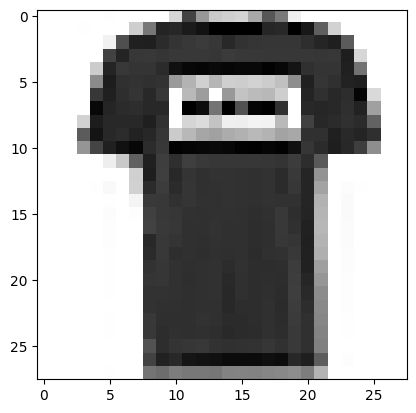

In [17]:
plt.imshow(x_data[1], cmap=plt.cm.binary)
plt.show()

# 1. Análisis de datos

### Veamos algunas imágenes de cada clase

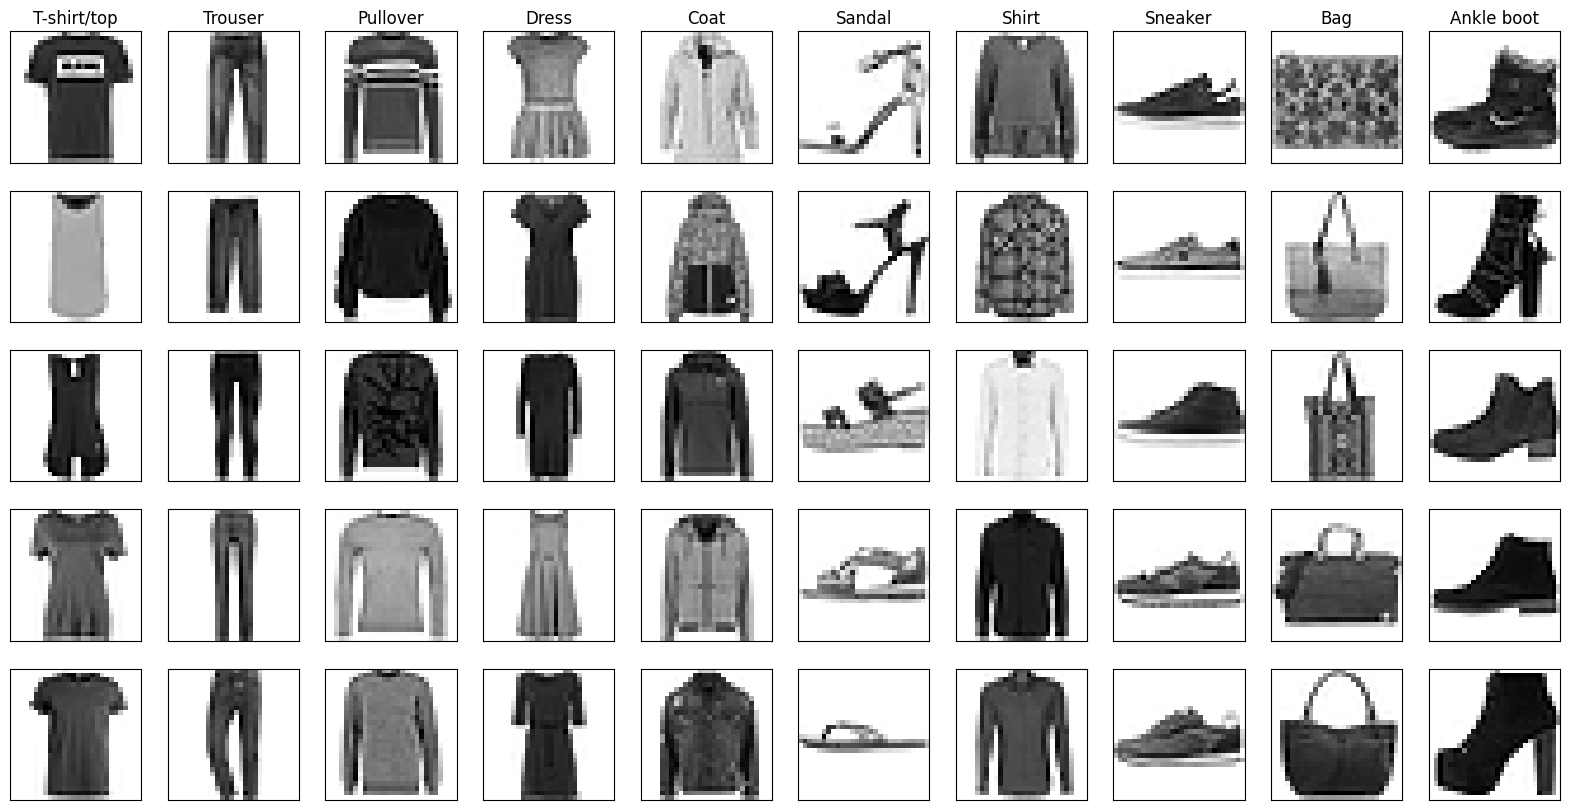

In [18]:
# Definimos los nombres de las clases
clases = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Muestra las primeras 5 imágenes de cada clase
plt.figure(figsize=(20,10))
for i in range(len(clases)):
  plt.subplot(5,10,i+1)
  plt.title(clases[i])
  for j in range(5):
    plt.subplot(5,10,1+i+10*j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_data[y_data == i][j], cmap=plt.cm.binary)
plt.show()

Cómo es el promedio de las clases?

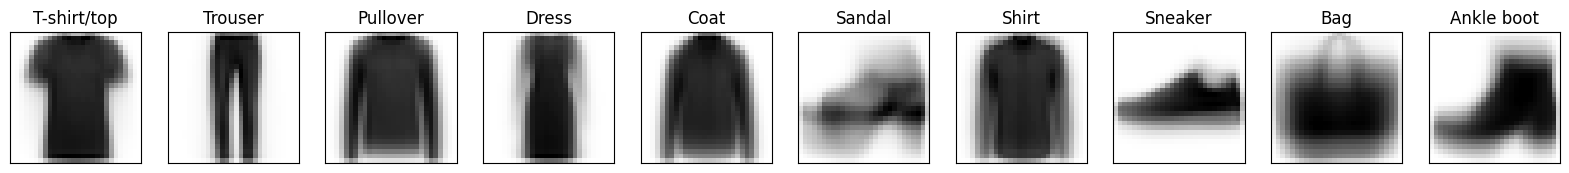

In [19]:
# Muestra el promedio de las clases
plt.figure(figsize=(20,10))
for i in range(len(clases)):
  plt.subplot(1,10,i+1)
  plt.title(clases[i])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.mean(x_data[y_data == i], 0), cmap=plt.cm.binary)
plt.show()

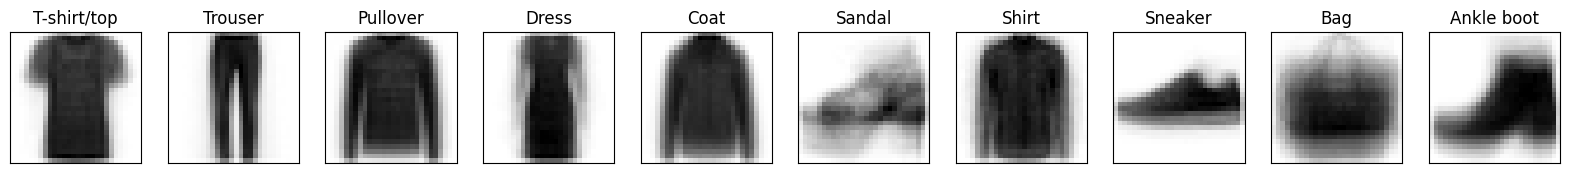

In [20]:
# Muestra el promedio de las primeras 100 imagenes de cada clase
plt.figure(figsize=(20,10))
for i in range(len(clases)):
  plt.subplot(1,10,i+1)
  plt.title(clases[i])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.mean(x_data[y_data == i][:100], 0), cmap=plt.cm.binary)
plt.show()

### Como están distribuidas las clases?

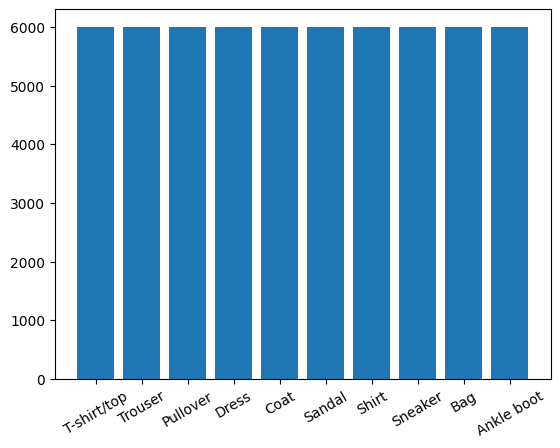

In [21]:
h, b = np.histogram(y_data, range=(0,10))
plt.bar(range(len(h)), h, tick_label=clases)
plt.xticks(rotation=30)
plt.show()

Se puede ver que la distribucion de clases es totalmente uniforme

## Data augmentation

In [22]:
newXData = x_data[:,:,::-1] # Espejamos todas la imagenes en el eje vertical
newYData = y_data

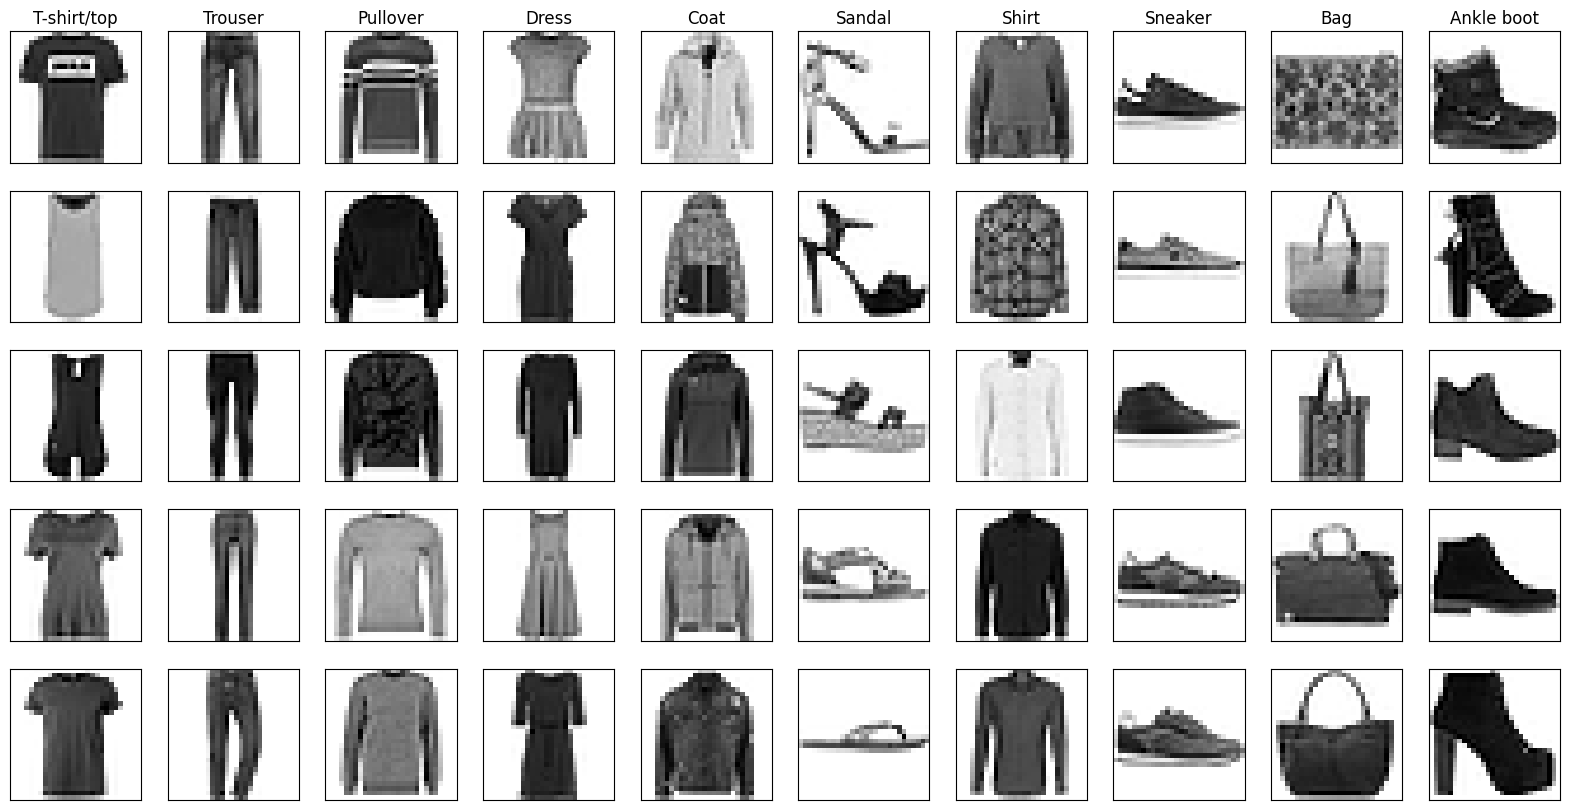

In [23]:
# Muestra las primeras 5 imágenes de cada clase
plt.figure(figsize=(20,10))
for i in range(len(clases)):
  plt.subplot(5,10,i+1)
  plt.title(clases[i])
  for j in range(5):
    plt.subplot(5,10,1+i+10*j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(newXData[newYData == i][j], cmap=plt.cm.binary)
plt.show()

In [24]:
x_data = np.append(x_data, newXData, axis=0)
y_data = np.append(y_data, newYData, axis=0)
print(len(x_data), len(y_data))

120000 120000


## Preprocesamiento

In [25]:
x_data = x_data / 255.0
x_test = x_test / 255.0

In [26]:
# Pasamos a one-hot encoding
y_datahot = keras.layers.CategoryEncoding(num_tokens=10, output_mode='one_hot')(y_data).numpy()
y_datahot.shape

(120000, 10)

In [27]:
# Separacion en train y validacion
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_datahot, random_state=99, train_size = .8)

In [28]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

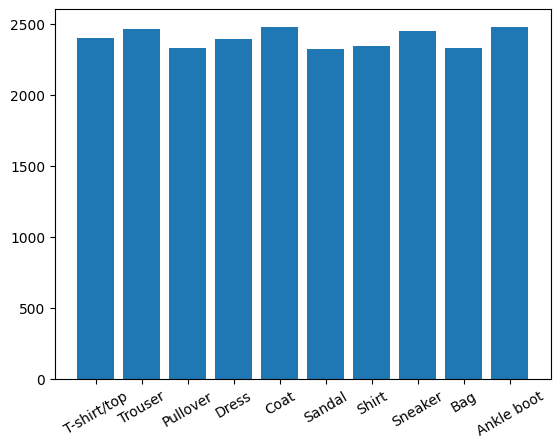

In [29]:
# Graficamos el histograma sobre el set de validacion
h, b = np.histogram(np.argmax(y_val, axis=-1), range=(0,10))
plt.bar(range(len(h)), h, tick_label=clases)
plt.xticks(rotation=30)
plt.show()

In [30]:
np.max(x_data)

1.0

In [31]:
# Early stop
earlyCb = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True, verbose=1)

Seteamos el early stop para monitorear la loss. La razón de esto es que al principio se monitoreaba el val_accuracy, pero se noto que en un punto del entrenamiento, el accuracy de validación subia, pero la loss también, y no tenía buen comportamiento en test.

# Métricas

Para el área bajo la curva ROC, F1-score, precision y recall hay dos maneras de medirlo para los casos multiclase: pomedio micro y macro.
En promedio micro, se calcula los falsos positivos y negativos totales, sin distinguir entre clases. Esto no es conveiente cuando las clases no están bien balanceadas. Para el promedio macro se calcula la métrica teniendo en cuenta solo los positivos y negativos de cada clase y luego se hace el promedio. 

Para el promedio macro del área bajo la curva ROC, hay dos estrategias: One vs Rest (OvR) y One vs One (OvO). En OvR se toma cada una de las clases como positiva, y se las compara contra todas las otras clases, luego se hace el promedio. En OvO, se toman todos los pares ordenados de clases y se toma una positiva y la otra negativa, luego se promedian los resultados

Para un problema muticlase como este, sería conveniente tomar el promedio macro OvO, ya que es el que mejor generaliza frente al desbalance de clases, sin embargo en este caso las clsaes se encuentran bien balanceadas y cualquiera de los promedios debería ser similar.

Para la curva ROC, se graficará la curva para cada classe, tomando en cada caso una clase como positiva y el resto como negativas (Estrategia OvR), ya que para mostrar el OvO, deberían graficarse 90 curvas en cada caso. Se enunciarán las metricas: Precision, Recall, F1-Score, AUC OvR y AUC OvO. 

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, precision_score, recall_score, f1_score, auc
def get_metrics(model):
  y_true = np.argmax(y_val, axis=-1)
  y_score = model.predict(x_val)
  y_pred = np.argmax(y_score, axis=-1)
  accuracy = sum(y_pred == y_true)/len(y_val)
  roc = [roc_curve(y_true, y_score[:,i], pos_label=i) for i in range(10)]   # OvR
  aucOvR = roc_auc_score(y_true, y_score, average='macro', multi_class='ovr')
  aucOvO = roc_auc_score(y_true, y_score, average='macro', multi_class='ovo')
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  
  for num, (fpr, tpr, th) in enumerate(roc):
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=f'{clases[num]} - AUC = {roc_auc:.4f}')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.title(model.name)
  plt.text(0.7, 0.65, (f'Accuracy: {accuracy:.4f}\nAUC OvR: {aucOvR:.4f}\nAUC OvO: {aucOvO:.4f}'
                      f'\nF1: {f1:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}'))
  plt.show()

# 2. Modelos

## Regresion Softmax

Model: "Softmax"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.8741 - accuracy: 0.7131 - val_loss: 0.6559 - val_accuracy: 0.7924
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 0.6205 - accuracy: 0.7969 - val_loss: 0.5859 - val_accuracy: 0.8082
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.5730 - accuracy: 0.8104 - val_loss: 0.5572 - val_accuracy: 0.8184
Epoch 4/100
375/375 [===

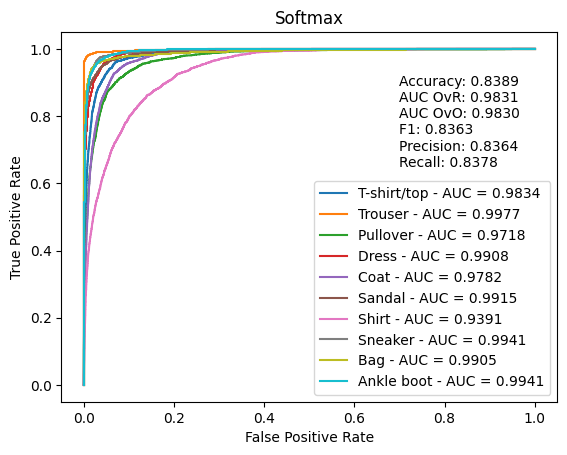

In [ ]:
modelSoft = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='softmax'),
], name='Softmax')

modelSoft.compile(optimizer="Adam",
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
modelSoft.summary()

fited = modelSoft.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val),
                      callbacks=[earlyCb])
get_metrics(modelSoft)

Se obtuvo un accuracy bastante mayor al 0.70 par un modelo tan simple. En la curva ROC se puede notar que la clasificación de la clase "shirt" es la que más le dificulta al modelo, probablemente por los parecidos con otras como "T-shirt", "Coat" o "Pullover".

In [23]:
# Con qué confunde la clase shirt?

y_true = np.argmax(y_val, axis=-1)
y_score = modelSoft.predict(x_val)
y_pred = np.argmax(y_score, axis=-1)
for i in range(10):
    print(f'{clases[i]}: {sum(y_pred[y_true == 6] == i)/len(y_pred[y_true == 6]):.4f}')

750/750 [==============================] - 1s 722us/step
T-shirt/top: 0.1641
Trouser: 0.0030
Pullover: 0.1130
Dress: 0.0328
Coat: 0.1078
Sandal: 0.0090
Shirt: 0.5473
Sneaker: 0.0013
Bag: 0.0183
Ankle boot: 0.0034


Efectivamente, "T-shirt", "Pullover" y "Coat" son las clases con las que más confunde "Shirt"

## Modelo base

Partimos del siguiente modelo

In [45]:
modelBase = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax'),
], name='Base')

In [46]:
modelBase.compile(optimizer="Adam",
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
modelBase.summary()

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               100480    
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
375/375 [==============================] - 2s 3ms/step - loss: 0.7750 - accuracy: 0.7560 - val_loss: 0.5374 - val_accuracy: 0.8203
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4944 - accuracy: 0.8303 - val_loss: 0.4537 - val_accuracy: 0.8433
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4360 - accuracy: 0.8478 - val_loss: 0.4151 - val_accuracy: 0.8530
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4030 - accuracy: 0.8577 - val_loss: 0.3956 - val_accuracy: 0.8589
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3807 - accuracy: 0.8651 - val_loss: 0.3729 - val_accuracy: 0.8668
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3617 - accuracy: 0.8726 - val_loss: 0.3602 - val_accuracy: 0.8708
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3475 - accuracy: 0.8764 - val_loss: 0.3503 - val_accuracy: 0.8747

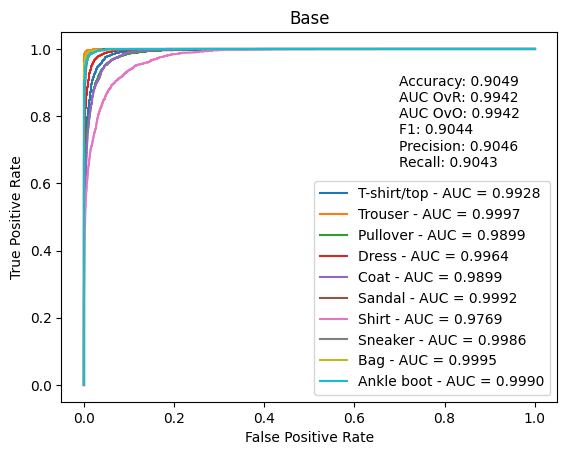

In [47]:
fited = modelBase.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val),
                      callbacks=[earlyCb])
get_metrics(modelBase)

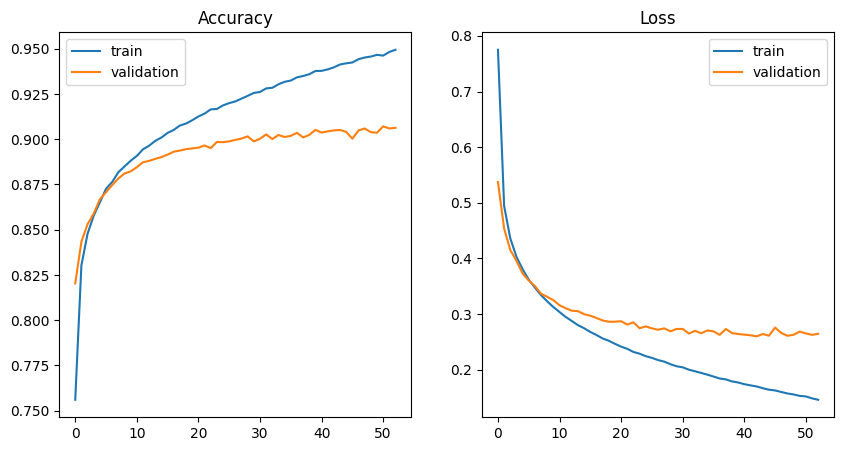

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(fited.history['accuracy'], label='train')
plt.plot(fited.history['val_accuracy'], label='validation')
plt.legend()
plt.subplot(1,2,2)
plt.title("Loss")
plt.plot(fited.history['loss'], label='train')
plt.plot(fited.history['val_loss'], label='validation')
plt.legend()
plt.show()

La capa intermedia logró una considerable mejora de la métrica principal, sin embargo seguimo viendo el problema con la clase "shirt"

# Cambiando el modelo (Tuner)

In [33]:
activations = ['sigmoid', 'relu', 'tanh']
optimizers = ['adam', 'sgd', 'rmsprop']
losses = ['categorical_crossentropy', 'mse', 'mae']

initials = ['glorot_uniform', 'glorot_normal', 'random_normal']

In [35]:
import keras_tuner as kt

def build_FMNIST_model(hp):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),        
        keras.layers.Dense(units=hp.Choice('units', [64, 128, 256]),
                                        activation=hp.Choice('activation', activations),
                                        kernel_initializer=hp.Choice('init', initials),
                                        bias_initializer=keras.initializers.Zeros()),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer=hp.Choice('optimizer', optimizers),
        loss=hp.Choice('loss', losses),
        metrics=["accuracy"],
    )
    return model

Resultan 243 modelos con todas las combinaciones posibles de activaciones, inicializadores, optimizadores y funcion de costo.

In [36]:
tuner = kt.GridSearch(build_FMNIST_model, objective='val_accuracy', project_name='tuner_project', overwrite=False)
tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from .\tuner_project\tuner0.json
Search space summary
Default search space size: 5
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu', 'tanh'], 'ordered': False}
init (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['glorot_uniform', 'glorot_normal', 'random_normal'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}
loss (Choice)
{'default': 'categorical_crossentropy', 'conditions': [], 'values': ['categorical_crossentropy', 'mse', 'mae'], 'ordered': False}


In [27]:
tuner.search(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val),
                      callbacks=[earlyCb], verbose=1)

Trial 243 Complete [00h 02m 35s]
val_accuracy: 0.7166666388511658

Best val_accuracy So Far: 0.9164999723434448
Total elapsed time: 06h 07m 34s
INFO:tensorflow:Oracle triggered exit


Después de 6hs de entrenamiento, podemos ver cuáles fueron los mejores modelos

In [6]:
tuner.results_summary()

Results summary
Results in .\tuner_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0163 summary
Hyperparameters:
units: 256
activation: sigmoid
init: glorot_uniform
optimizer: adam
loss: mse
Score: 0.9164999723434448

Trial 0181 summary
Hyperparameters:
units: 256
activation: sigmoid
init: random_normal
optimizer: adam
loss: mse
Score: 0.9152500033378601

Trial 0162 summary
Hyperparameters:
units: 256
activation: sigmoid
init: glorot_uniform
optimizer: adam
loss: categorical_crossentropy
Score: 0.9147916436195374

Trial 0172 summary
Hyperparameters:
units: 256
activation: sigmoid
init: glorot_normal
optimizer: adam
loss: mse
Score: 0.9146249890327454

Trial 0240 summary
Hyperparameters:
units: 256
activation: tanh
init: random_normal
optimizer: rmsprop
loss: categorical_crossentropy
Score: 0.9146249890327454

Trial 0226 summary
Hyperparameters:
units: 256
activation: tanh
init: glorot_normal
optimizer: adam
loss: mse
Score: 0.9144999980926514

Tria

Podemos notar que todos tienen la máxima cantidad de unidades (256), la sigmoidea parecería ser la mejor función de activación, seguida de la tanh, los inicializadores aparecieron todos, el mejor optimizador parece ser adam y sorprendentemente el MSE para función de costo parece funcionar mejor en muchos casos que la categorical crossentropy.

Veamos las métricas de los mejores 5 modelos

750/750 [==============================] - 1s 2ms/step


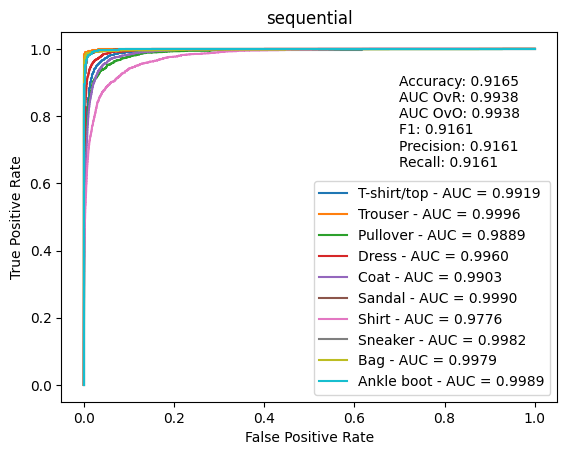

750/750 [==============================] - 1s 1ms/step


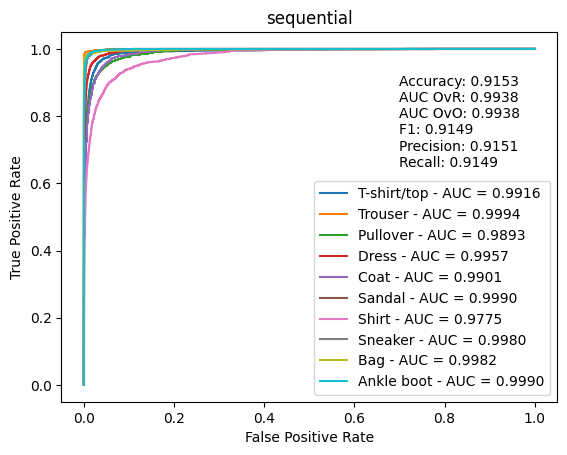

750/750 [==============================] - 1s 1ms/step


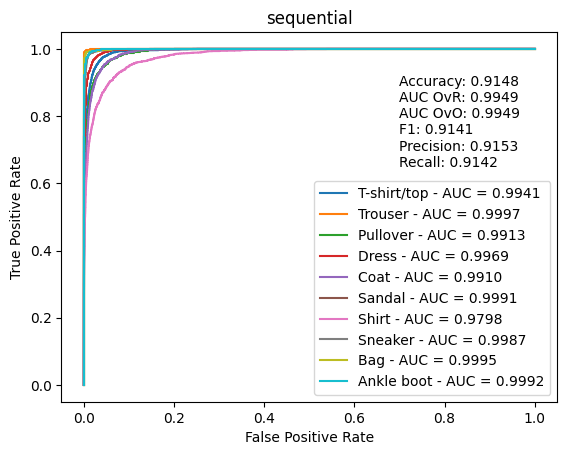

750/750 [==============================] - 1s 1ms/step


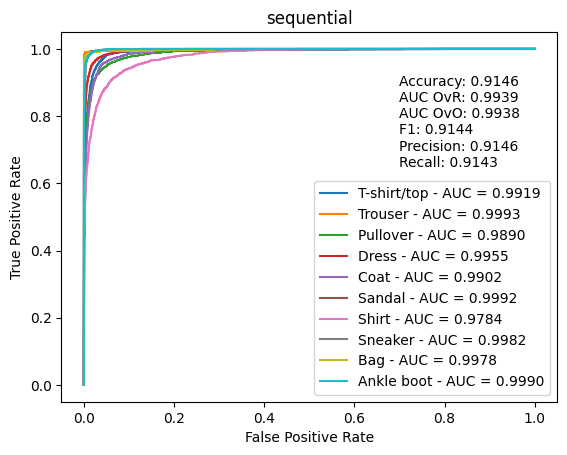

750/750 [==============================] - 1s 1ms/step


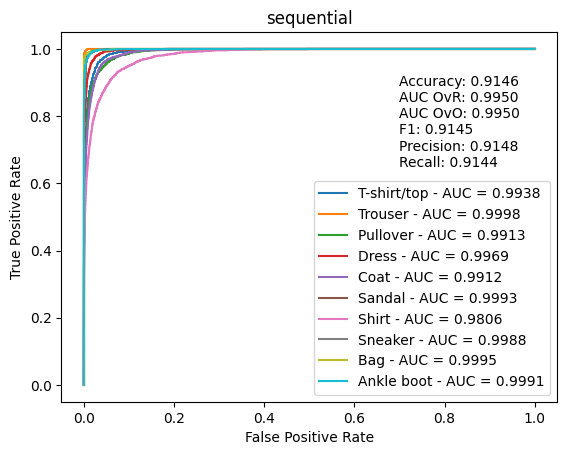

In [37]:
models = tuner.get_best_models(5)
for model in models:
    get_metrics(model)

Todas las curvas son muy parecidas, evidentemente el problema con la clase "shirt" es propio de los datos.

## Modelo de más capas

Usando los resultados obtenidos con una capa, podemos aumentar la cantidad de capas para ver si logramos mejorar el modelo.

In [24]:
activations2 = ['sigmoid', 'relu', 'tanh']
losses2 = ['categorical_crossentropy', 'mse']

def build_FMNIST_model2(hp):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),        
        keras.layers.Dense(units=hp.Choice('units1', [128, 256]),
                                        activation=hp.Choice('activation1', activations2),
                                        kernel_initializer='glorot_uniform',
                                        bias_initializer=keras.initializers.Zeros()),
        keras.layers.Dense(units=hp.Choice('units2', [128, 256]),
                                        activation=hp.Choice('activation2', activations2),
                                        kernel_initializer='glorot_uniform',
                                        bias_initializer=keras.initializers.Zeros()),
        keras.layers.Dense(10, activation="softmax")
    ], name='Tuner2Capas')
    model.compile(
        optimizer='adam',
        loss=hp.Choice('loss', losses2),
        metrics=["accuracy"],
    )
    return model

In [25]:
tuner2 = kt.GridSearch(build_FMNIST_model2, objective='val_accuracy', project_name='tuner_project2', overwrite=False)
tuner2.search_space_summary()

INFO:tensorflow:Reloading Tuner from .\tuner_project2\tuner0.json
Search space summary
Default search space size: 5
units1 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
activation1 (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu', 'tanh'], 'ordered': False}
units2 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
activation2 (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu', 'tanh'], 'ordered': False}
loss (Choice)
{'default': 'categorical_crossentropy', 'conditions': [], 'values': ['categorical_crossentropy', 'mse'], 'ordered': False}


In [83]:
tuner2.search(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val),
                      callbacks=[earlyCb])

Trial 72 Complete [00h 02m 25s]
val_accuracy: 0.9311666488647461

Best val_accuracy So Far: 0.9312916398048401
Total elapsed time: 01h 23m 42s
INFO:tensorflow:Oracle triggered exit


In [86]:
tuner2.results_summary()

Results summary
Results in .\tuner_project2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0055 summary
Hyperparameters:
units1: 256
activation1: relu
units2: 256
activation2: sigmoid
loss: mse
Score: 0.9312916398048401

Trial 0071 summary
Hyperparameters:
units1: 256
activation1: tanh
units2: 256
activation2: tanh
loss: mse
Score: 0.9311666488647461

Trial 0049 summary
Hyperparameters:
units1: 256
activation1: relu
units2: 128
activation2: sigmoid
loss: mse
Score: 0.9284166693687439

Trial 0059 summary
Hyperparameters:
units1: 256
activation1: relu
units2: 256
activation2: tanh
loss: mse
Score: 0.9271666407585144

Trial 0019 summary
Hyperparameters:
units1: 128
activation1: relu
units2: 256
activation2: sigmoid
loss: mse
Score: 0.9265833497047424

Trial 0069 summary
Hyperparameters:
units1: 256
activation1: tanh
units2: 256
activation2: relu
loss: mse
Score: 0.9262083172798157

Trial 0023 summary
Hyperparameters:
units1: 128
activation1: relu
units2: 256

750/750 [==============================] - 1s 2ms/step


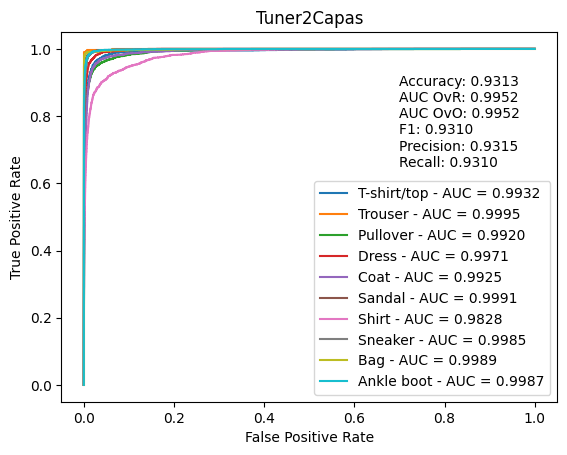

750/750 [==============================] - 1s 1ms/step


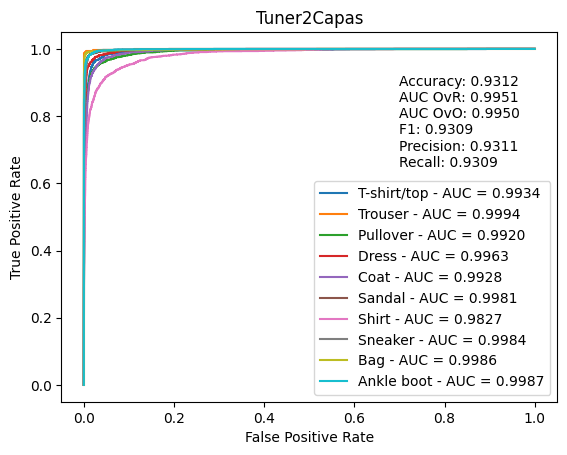

750/750 [==============================] - 1s 1ms/step


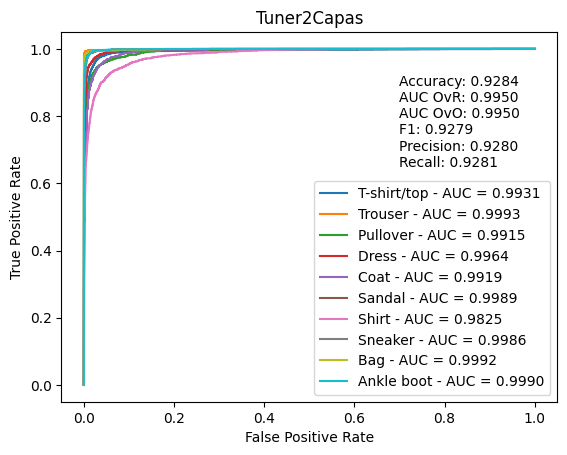

750/750 [==============================] - 1s 1ms/step


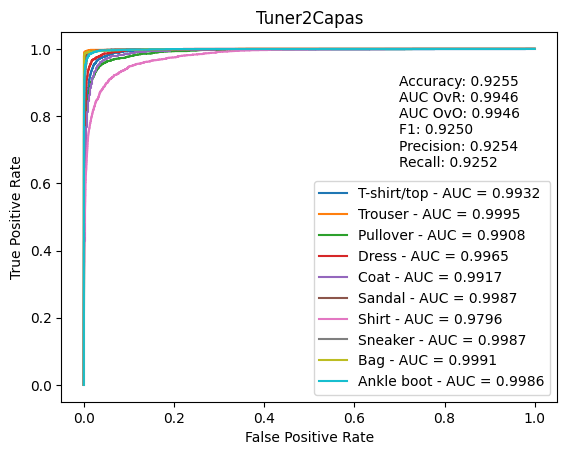

750/750 [==============================] - 1s 913us/step


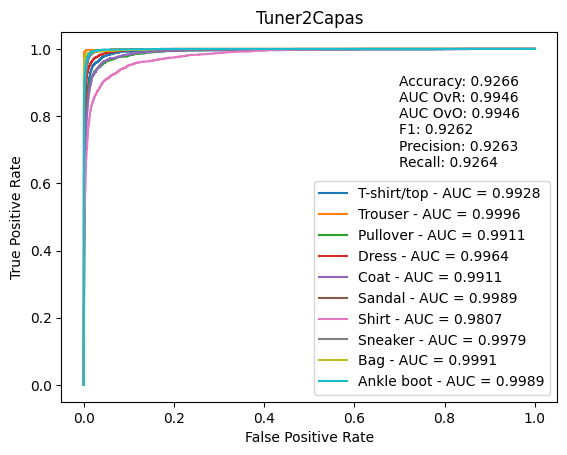

In [26]:
models2 = tuner2.get_best_models(5)
for model in models2:
    get_metrics(model)

Vemos que se logró mas de 0.93 en validación con 2 capas

## Variación de hiperparámetros

A partir de ahora, trabajamos con el mejor modelo. Iremos variando y grficando el cambio a otros hiperparametros.

Guardamos los pesos e inicializamos un nuevo modelo para hacer las pruebas

In [27]:
models2[0].summary()
models2[0].save_weights('weights/models2_0')
best_hp = tuner2.get_best_hyperparameters()[0]
print(best_hp.values)

Model: "Tuner2Capas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
{'units1': 256, 'activation1': 'relu', 'units2': 256, 'activation2': 'sigmoid', 'loss': 'mse'}


750/750 [==============================] - 1s 1ms/step


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\scikit_learn-1.0.2-py3.9-win-amd64.egg\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


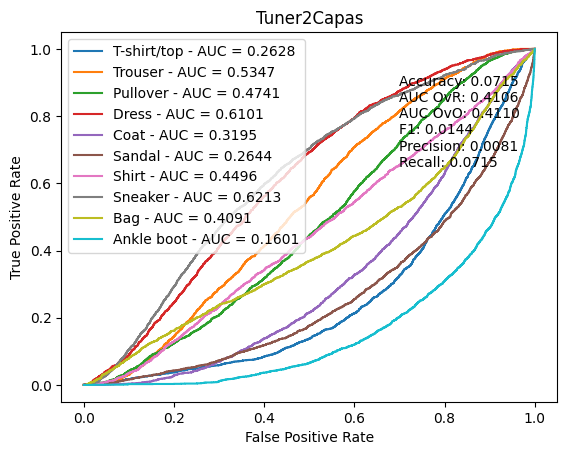

In [28]:
model = tuner2.hypermodel.build(best_hp)
get_metrics(model)
model.save_weights('weights/init_weights')

### Variacion del learning rate

In [101]:
learnings = np.logspace(-6, 0, 10) # 10 valores de 1e-6 a 1

accs = np.empty(len(learnings))
iters = np.empty(len(learnings), dtype=int)

for i, lr in enumerate(learnings):
    model.load_weights('weights/init_weights')      # Reinicializacion de pesos
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=best_hp['loss'],
        metrics=['accuracy'],
        )
    fited = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[earlyCb])
    if earlyCb.stopped_epoch > 0:
        iters[i] = earlyCb.stopped_epoch
    else:
        iters[i] = fited.epoch[-1]
    accs[i] = fited.history['val_accuracy'][iters[i]]
    iters[i] *= len(x_train)/256        # iteraciones = epochs*(batches/epoch)


Epoch 1/100
375/375 [==============================] - 3s 6ms/step - loss: 0.0916 - accuracy: 0.1691 - val_loss: 0.0910 - val_accuracy: 0.1926
Epoch 2/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0902 - accuracy: 0.2219 - val_loss: 0.0897 - val_accuracy: 0.2482
Epoch 3/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0890 - accuracy: 0.2765 - val_loss: 0.0884 - val_accuracy: 0.2943
Epoch 4/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0878 - accuracy: 0.3200 - val_loss: 0.0872 - val_accuracy: 0.3418
Epoch 5/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0866 - accuracy: 0.3756 - val_loss: 0.0859 - val_accuracy: 0.3992
Epoch 6/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0853 - accuracy: 0.4199 - val_loss: 0.0847 - val_accuracy: 0.4370
Epoch 7/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0840 - accuracy: 0.4496 - val_loss: 0.0834 - val_accuracy: 0.4595

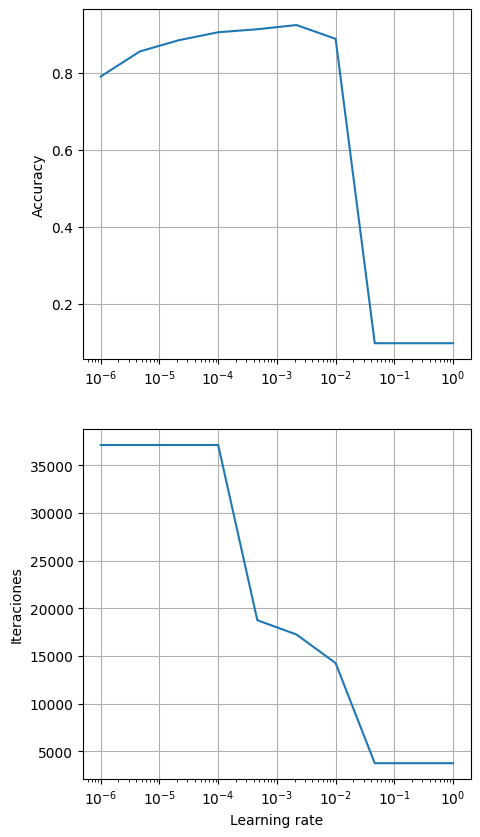

In [114]:
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.ylabel('Accuracy')
plt.semilogx(learnings, accs)
plt.grid()
plt.subplot(2,1,2)
plt.ylabel('Iteraciones')
plt.xlabel('Learning rate')
plt.semilogx(learnings, iters)
plt.grid()
plt.show()

Se puede ver que antes de 1e-4, no llegaba a terminar de entrenar, ya que el accuracy era bajo y no ortaba por earlystop.

Entre 1e-4 y 1e-2 entrena bien. Luego, el lr es muy grande y corta temprano con accuracy muy bajo.

### Variación del batch_size

In [116]:
batches = [2**n for n in range(5, 11)]  # Desde 2^5 hasta 2^10

accs = np.empty(len(batches))
iters = np.empty(len(batches), dtype=int)

for i, batch in enumerate(batches):
    model.load_weights('weights/init_weights')      # Reinicializacion de pesos
    model.compile(
        optimizer='adam',
        loss=best_hp['loss'],
        metrics=['accuracy'],
        )
    fited = model.fit(x_train, y_train, batch_size=batch, epochs=100, validation_data=(x_val, y_val), callbacks=[earlyCb])
    if earlyCb.stopped_epoch > 0:
        iters[i] = earlyCb.stopped_epoch
    else:
        iters[i] = fited.epoch[-1]
    accs[i] = fited.history['val_accuracy'][iters[i]]
    iters[i] *= len(x_train)/256        # iteraciones = epochs*(batches/epoch)

Epoch 1/100
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0243 - accuracy: 0.8303 - val_loss: 0.0240 - val_accuracy: 0.8319
Epoch 2/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0186 - accuracy: 0.8702 - val_loss: 0.0188 - val_accuracy: 0.8696
Epoch 3/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0169 - accuracy: 0.8834 - val_loss: 0.0163 - val_accuracy: 0.8852
Epoch 4/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0157 - accuracy: 0.8913 - val_loss: 0.0166 - val_accuracy: 0.8872
Epoch 5/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0148 - accuracy: 0.8985 - val_loss: 0.0173 - val_accuracy: 0.8834
Epoch 6/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0140 - accuracy: 0.9045 - val_loss: 0.0159 - val_accuracy: 0.8900
Epoch 7/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0133 - accuracy: 0.9096 - val_loss: 0.0152 - val_a

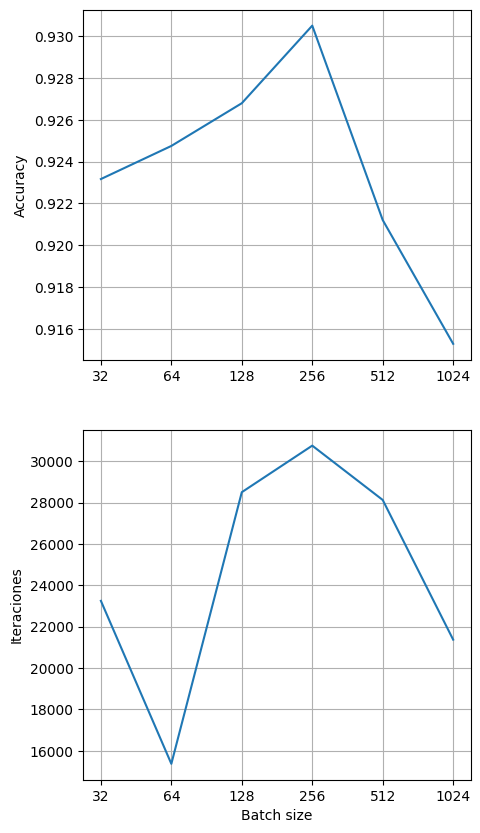

In [138]:
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.ylabel('Accuracy')
plt.plot(accs)
plt.xticks(range(len(batches)), labels=batches)
plt.grid()
plt.subplot(2,1,2)
plt.ylabel('Iteraciones')
plt.plot(iters)
plt.xticks(range(len(batches)), labels=batches)
plt.xlabel('Batch size')
plt.grid()
plt.show()

Se puede ver claramente un pico en accuracy y cantidad de entrenamientos para batch size de 256

### Variación de optimizadores

In [168]:
optimizers = ['adam', 'sgd', 'rmsprop', 'adamax', 'adadelta', 'adagrad']

accs = np.empty(len(optimizers))
iters = np.empty(len(optimizers), dtype=int)

for i, opt in enumerate(optimizers):
    model.load_weights('weights/init_weights')      # Reinicializacion de pesos
    model.compile(
        optimizer=opt,
        loss=best_hp['loss'],
        metrics=['accuracy'],
        )
    fited = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[earlyCb])
    if earlyCb.stopped_epoch > 0:
        iters[i] = earlyCb.stopped_epoch
    else:
        iters[i] = fited.epoch[-1]
    accs[i] = fited.history['val_accuracy'][iters[i]]
    iters[i] *= len(x_train)/256        # iteraciones = epochs*(batches/epoch)

Epoch 1/100
375/375 [==============================] - 3s 7ms/step - loss: 0.0285 - accuracy: 0.8017 - val_loss: 0.0217 - val_accuracy: 0.8482
Epoch 2/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0198 - accuracy: 0.8640 - val_loss: 0.0182 - val_accuracy: 0.8736
Epoch 3/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0179 - accuracy: 0.8766 - val_loss: 0.0173 - val_accuracy: 0.8791
Epoch 4/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0167 - accuracy: 0.8853 - val_loss: 0.0167 - val_accuracy: 0.8852
Epoch 5/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0159 - accuracy: 0.8913 - val_loss: 0.0165 - val_accuracy: 0.8865
Epoch 6/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0151 - accuracy: 0.8965 - val_loss: 0.0157 - val_accuracy: 0.8929
Epoch 7/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0145 - accuracy: 0.9015 - val_loss: 0.0158 - val_accuracy: 0.8915

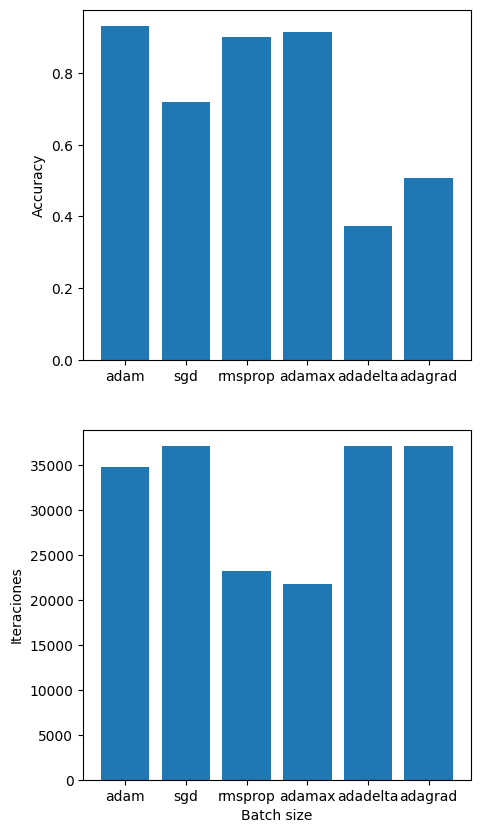

In [172]:
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.ylabel('Accuracy')
plt.bar(optimizers, accs)
plt.subplot(2,1,2)
plt.ylabel('Iteraciones')
plt.bar(optimizers, iters)
plt.xlabel('Batch size')
plt.show()

Como ya habíamos determinado, adam da el mejor accuracy para este modelo, pero se puede ver que hay otros optimizadores muy buenos y que tardan mucho menos

### Variación de activaciones

In [176]:
activations = ['sigmoid', 'relu', 'tanh', 'leakyrelu']

accs = np.empty((len(activations), len(activations)))
iters = np.empty((len(activations), len(activations)), dtype=int)

for i, act1 in enumerate(activations):
    for j, act2 in enumerate(activations):
        model = keras.Sequential(name=f'activation_{act1}-{act2}')
        model.add(keras.layers.Flatten(input_shape=(28, 28)))        
        model.add(keras.layers.Dense(units=best_hp['units1'],
                                            activation=act1 if act1 != 'leakyrelu' else 'linear',
                                            kernel_initializer='glorot_uniform',
                                            bias_initializer=keras.initializers.Zeros()))
            
        if act1 == 'leakyrelu':
            model.add(keras.layers.LeakyReLU())

        model.add(keras.layers.Dense(units=best_hp['units2'],
                                            activation=act2 if act2 != 'leakyrelu' else 'linear',
                                            kernel_initializer='glorot_uniform',
                                            bias_initializer=keras.initializers.Zeros()))
        if act2 == 'leakyrelu':
            model.add(keras.layers.LeakyReLU())

        model.add(keras.layers.Dense(10, activation="softmax"))

        model.compile(
            optimizer='adam',
            loss=best_hp['loss'],
            metrics=['accuracy'],
        )
        fited = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[earlyCb])
        if earlyCb.stopped_epoch > 0:
            iters[i][j] = earlyCb.stopped_epoch
        else:
            iters[i][j] = fited.epoch[-1]
        accs[i][j] = fited.history['val_accuracy'][iters[i][j]]
        iters[i][j] *= len(x_train)/256        # iteraciones = epochs*(batches/epoch)

Epoch 1/100
375/375 [==============================] - 3s 6ms/step - loss: 0.0364 - accuracy: 0.7442 - val_loss: 0.0250 - val_accuracy: 0.8275
Epoch 2/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0228 - accuracy: 0.8424 - val_loss: 0.0211 - val_accuracy: 0.8538
Epoch 3/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0203 - accuracy: 0.8591 - val_loss: 0.0191 - val_accuracy: 0.8677
Epoch 4/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0190 - accuracy: 0.8687 - val_loss: 0.0190 - val_accuracy: 0.8683
Epoch 5/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0180 - accuracy: 0.8769 - val_loss: 0.0184 - val_accuracy: 0.8732
Epoch 6/100
375/375 [==============================] - 2s 7ms/step - loss: 0.0172 - accuracy: 0.8827 - val_loss: 0.0172 - val_accuracy: 0.8818
Epoch 7/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0167 - accuracy: 0.8858 - val_loss: 0.0174 - val_accuracy: 0.8788

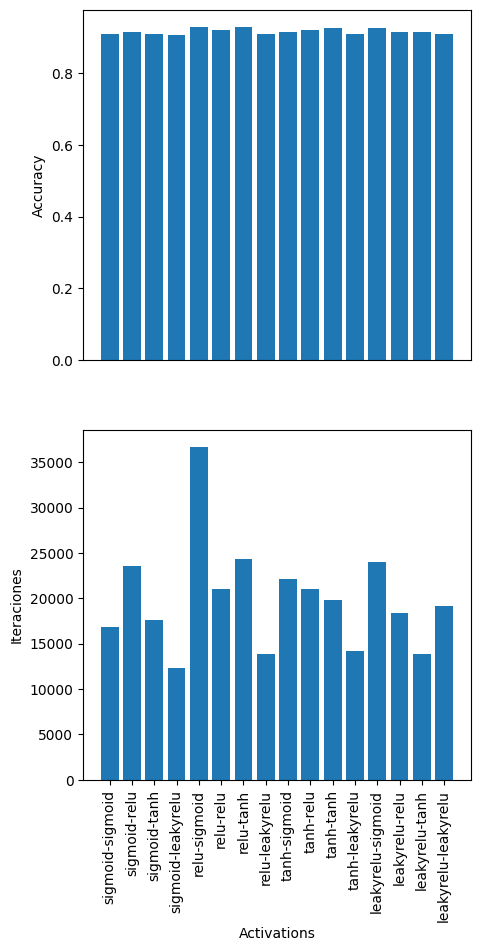

In [194]:
activNames = [act1 + '-' + act2 for act1 in activations for act2 in activations]
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.ylabel('Accuracy')
plt.bar(activNames, accs.flatten())
plt.xticks([])
plt.subplot(2,1,2)
plt.ylabel('Iteraciones')
plt.bar(activNames, iters.flatten())
plt.xticks(rotation=90)
plt.xlabel('Activations')
plt.show()

Se puede ver que no hay gran diferencia para el accuracy, aunque una leve mejora en relu-sigmoid. Sin embago, baja notoriamente la cantidad de iteraciones para algunas funciones

### Variación de dropout rate

In [199]:
dropouts = np.linspace(0, 0.75, 16)

accs = np.empty(len(dropouts))
iters = np.empty(len(dropouts), dtype=int)

for i, drpt in enumerate(dropouts):
    model = keras.Sequential(name=f'dropout_{drpt}')
    model.add(keras.layers.Flatten(input_shape=(28, 28)))        
    model.add(keras.layers.Dense(units=best_hp['units1'],
                                        activation=best_hp['activation1'],
                                        kernel_initializer='glorot_uniform',
                                        bias_initializer=keras.initializers.Zeros()))
    model.add(keras.layers.Dropout(rate=drpt))

    model.add(keras.layers.Dense(units=best_hp['units2'],
                                        activation=best_hp['activation2'],
                                        kernel_initializer='glorot_uniform',
                                        bias_initializer=keras.initializers.Zeros()))
    model.add(keras.layers.Dropout(rate=drpt))
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer='adam',
        loss=best_hp['loss'],
        metrics=['accuracy'],
    )
    fited = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[earlyCb])
    if earlyCb.stopped_epoch > 0:
        iters[i] = earlyCb.stopped_epoch
    else:
        iters[i] = fited.epoch[-1]
    accs[i] = fited.history['val_accuracy'][iters[i]]
    iters[i] *= len(x_train)/256        # iteraciones = epochs*(batches/epoch)

Epoch 1/100
375/375 [==============================] - 5s 11ms/step - loss: 0.0286 - accuracy: 0.8013 - val_loss: 0.0212 - val_accuracy: 0.8508
Epoch 2/100
375/375 [==============================] - 4s 11ms/step - loss: 0.0199 - accuracy: 0.8631 - val_loss: 0.0183 - val_accuracy: 0.8739
Epoch 3/100
375/375 [==============================] - 4s 11ms/step - loss: 0.0182 - accuracy: 0.8743 - val_loss: 0.0181 - val_accuracy: 0.8743
Epoch 4/100
375/375 [==============================] - 4s 11ms/step - loss: 0.0168 - accuracy: 0.8848 - val_loss: 0.0169 - val_accuracy: 0.8819
Epoch 5/100
375/375 [==============================] - 4s 10ms/step - loss: 0.0159 - accuracy: 0.8921 - val_loss: 0.0158 - val_accuracy: 0.8905
Epoch 6/100
375/375 [==============================] - 4s 10ms/step - loss: 0.0153 - accuracy: 0.8956 - val_loss: 0.0167 - val_accuracy: 0.8847
Epoch 7/100
375/375 [==============================] - 4s 10ms/step - loss: 0.0146 - accuracy: 0.9005 - val_loss: 0.0160 - val_accuracy:

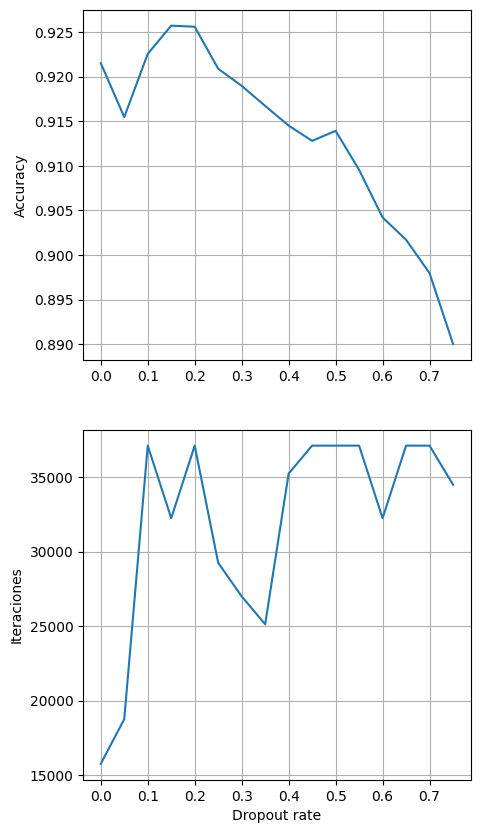

In [200]:
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.ylabel('Accuracy')
plt.plot(dropouts, accs)
plt.grid()
plt.subplot(2,1,2)
plt.ylabel('Iteraciones')
plt.plot(dropouts, iters)
plt.xlabel('Dropout rate')
plt.grid()
plt.show()

El dropout de 0.15 fue el de mayor accuracy y menor cantidad de iteraciones 

### Variación de Batch normalization

In [201]:
batchn = [False, True]

accs = np.empty(len(batchn))
iters = np.empty(len(batchn), dtype=int)

for i, batch in enumerate(batchn):
    model = keras.Sequential(name=f'batch_{batch}')
    model.add(keras.layers.Flatten(input_shape=(28, 28)))        
    model.add(keras.layers.Dense(units=best_hp['units1'],
                                        activation=best_hp['activation1'],
                                        kernel_initializer='glorot_uniform',
                                        bias_initializer=keras.initializers.Zeros()))
    if (batch):
        model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(units=best_hp['units2'],
                                        activation=best_hp['activation2'],
                                        kernel_initializer='glorot_uniform',
                                        bias_initializer=keras.initializers.Zeros()))
    if (batch):
        model.add(keras.layers.BatchNormalization())
        
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer='adam',
        loss=best_hp['loss'],
        metrics=['accuracy'],
    )
    fited = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[earlyCb])
    if earlyCb.stopped_epoch > 0:
        iters[i] = earlyCb.stopped_epoch
    else:
        iters[i] = fited.epoch[-1]
    accs[i] = fited.history['val_accuracy'][iters[i]]
    iters[i] *= len(x_train)/256        # iteraciones = epochs*(batches/epoch)

Epoch 1/100
375/375 [==============================] - 3s 6ms/step - loss: 0.0299 - accuracy: 0.7888 - val_loss: 0.0217 - val_accuracy: 0.8490
Epoch 2/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0201 - accuracy: 0.8605 - val_loss: 0.0208 - val_accuracy: 0.8533
Epoch 3/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0183 - accuracy: 0.8737 - val_loss: 0.0176 - val_accuracy: 0.8778
Epoch 4/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0168 - accuracy: 0.8844 - val_loss: 0.0164 - val_accuracy: 0.8863
Epoch 5/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0159 - accuracy: 0.8917 - val_loss: 0.0158 - val_accuracy: 0.8922
Epoch 6/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0151 - accuracy: 0.8972 - val_loss: 0.0154 - val_accuracy: 0.8947
Epoch 7/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0144 - accuracy: 0.9023 - val_loss: 0.0156 - val_accuracy: 0.8926

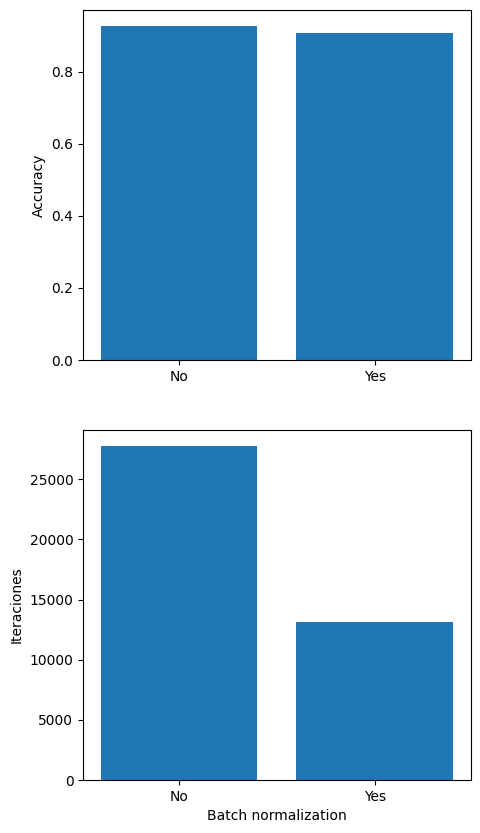

In [206]:
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.ylabel('Accuracy')
plt.bar(batchn, accs)
plt.xticks(batchn, labels=['No', 'Yes'])
plt.subplot(2,1,2)
plt.ylabel('Iteraciones')
plt.bar(batchn, iters)
plt.xticks(batchn, labels=['No', 'Yes'])
plt.xlabel('Batch normalization')
plt.show()

Sin batch normalization tenemos una pequeña mejora en accuracy, al costo de casi el doble de iteraciones.

### Variación de inicialización de pesos

In [99]:
initials = ['glorot_uniform', 'glorot_normal',
            'random_normal', 'rn_001']

accs = np.empty(len(initials))
iters = np.empty(len(initials), dtype=int)

for i, init in enumerate(initials):
    model = keras.Sequential(name=f'initial_{init}')
    model.add(keras.layers.Flatten(input_shape=(28, 28)))        
    model.add(keras.layers.Dense(units=best_hp['units1'],
                                        activation=best_hp['activation1'],
                                        kernel_initializer= init if init != 'rn_001' else keras.initializers.RandomNormal(mean=0., stddev=0.001),
                                        bias_initializer=keras.initializers.Zeros()))
    
    model.add(keras.layers.Dense(units=best_hp['units2'],
                                        activation=best_hp['activation2'],
                                        kernel_initializer= init if init != 'rn_001' else keras.initializers.RandomNormal(mean=0., stddev=0.001),
                                        bias_initializer=keras.initializers.Zeros()))
        
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer='adam',
        loss=best_hp['loss'],
        metrics=['accuracy'],
    )
    fited = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[earlyCb])
    if earlyCb.stopped_epoch > 0:
        iters[i] = earlyCb.stopped_epoch
    else:
        iters[i] = fited.epoch[-1]
    accs[i] = fited.history['val_accuracy'][iters[i]]
    iters[i] *= len(x_train)/256        # iteraciones = epochs*(batches/epoch)

Epoch 1/100
375/375 [==============================] - 3s 6ms/step - loss: 0.0287 - accuracy: 0.7996 - val_loss: 0.0210 - val_accuracy: 0.8570
Epoch 2/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0199 - accuracy: 0.8628 - val_loss: 0.0195 - val_accuracy: 0.8660
Epoch 3/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0182 - accuracy: 0.8748 - val_loss: 0.0181 - val_accuracy: 0.8754
Epoch 4/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0169 - accuracy: 0.8838 - val_loss: 0.0169 - val_accuracy: 0.8822
Epoch 5/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0159 - accuracy: 0.8913 - val_loss: 0.0161 - val_accuracy: 0.8892
Epoch 6/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0152 - accuracy: 0.8962 - val_loss: 0.0157 - val_accuracy: 0.8921
Epoch 7/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0143 - accuracy: 0.9020 - val_loss: 0.0159 - val_accuracy: 0.8907

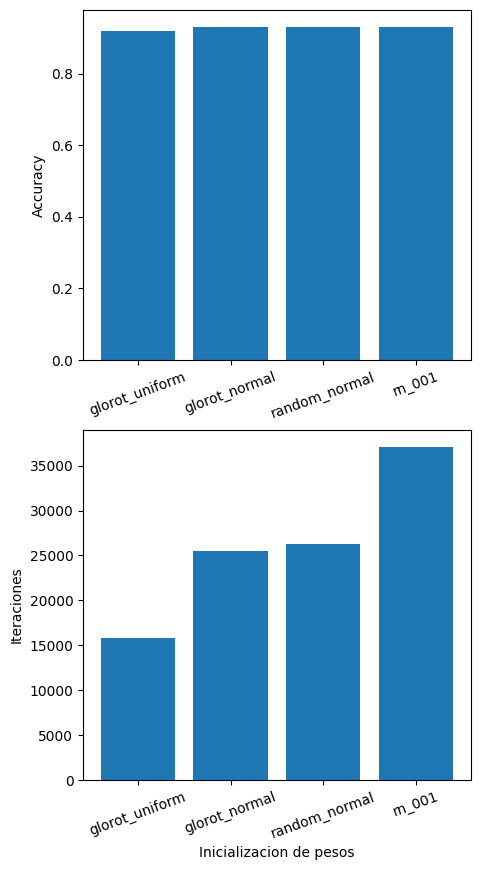

In [100]:
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.ylabel('Accuracy')
plt.bar(initials, accs)
plt.xticks(rotation=20)
plt.subplot(2,1,2)
plt.ylabel('Iteraciones')
plt.bar(initials, iters)
plt.xticks(rotation=20)
plt.xlabel('Inicializacion de pesos')
plt.show()

Se puede ver que el modelo converge a un accuracy muy similar para cualquier inicialización de pesos. Sin embargo, glorot_uniform tiene una ventaja en la cantidad de iteraciones necesarias.

# 3. Agregando capa embedding

Al mejor modelo que teníamos, le agregamos el droppout que mejor se comportaba (0.15)

In [30]:
embModel = keras.Sequential(name='ModelEmb')
embModel.add(keras.layers.Flatten(input_shape=(28, 28)))        
embModel.add(keras.layers.Dense(units=best_hp['units1'],
                                    activation=best_hp['activation1'],
                                    kernel_initializer='glorot_uniform',
                                    bias_initializer=keras.initializers.Zeros()))
embModel.add(keras.layers.Dropout(rate=0.15))

embModel.add(keras.layers.Dense(units=best_hp['units2'],
                                    activation=best_hp['activation2'],
                                    kernel_initializer='glorot_uniform',
                                    bias_initializer=keras.initializers.Zeros()))
embModel.add(keras.layers.Dropout(rate=0.15))
    
embModel.add(keras.layers.Dense(2, activation='sigmoid'))    # Capa intermedia. Activacion sigmoidea para que los datos queden entre 0 y 1

embModel.add(keras.layers.Dense(10, activation="softmax"))

embModel.compile(
    optimizer='adam',
    loss=best_hp['loss'],
    metrics=['accuracy'],
)

In [32]:
fited = embModel.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[earlyCb])

Epoch 1/100
375/375 [==============================] - 2s 7ms/step - loss: 0.0189 - accuracy: 0.8503 - val_loss: 0.0234 - val_accuracy: 0.8167
Epoch 2/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0189 - accuracy: 0.8490 - val_loss: 0.0234 - val_accuracy: 0.8297
Epoch 3/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0190 - accuracy: 0.8496 - val_loss: 0.0233 - val_accuracy: 0.8177
Epoch 4/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0189 - accuracy: 0.8493 - val_loss: 0.0235 - val_accuracy: 0.8236
Epoch 5/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0188 - accuracy: 0.8514 - val_loss: 0.0232 - val_accuracy: 0.8269
Epoch 6/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0187 - accuracy: 0.8517 - val_loss: 0.0234 - val_accuracy: 0.8168
Epoch 7/100
375/375 [==============================] - 2s 6ms/step - loss: 0.0186 - accuracy: 0.8522 - val_loss: 0.0232 - val_accuracy: 0.8187

750/750 [==============================] - 1s 1ms/step


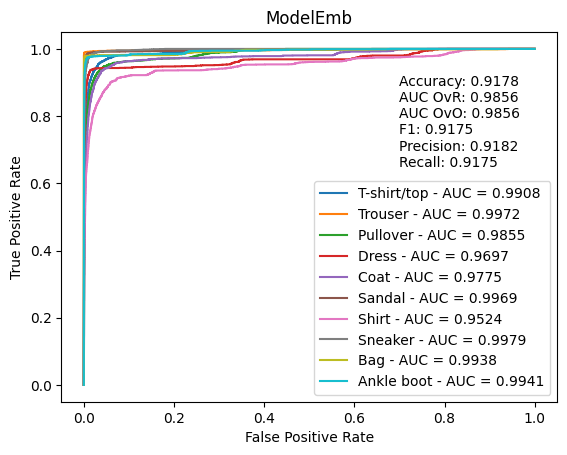

In [33]:
get_metrics(embModel)

Al parecer esas dos capas le dan un comportamiento distinto al modelo, aunque el accuracy es bastante bueno

In [34]:
embModel.save_weights('weights/embModel')

In [91]:
embModel.load_weights('weights/embModel')

In [35]:
X, Y = np.mgrid[0:1:255j, 0:1:255j]   # Grilla de 255x255
print(X.shape, Y.shape)

(255, 255) (255, 255)


In [36]:
# Creamos submodelo con entrada y salida en la ultima capa
embInModel = keras.Model(inputs=embModel.layers[-1].input,
                        outputs=embModel.output)

inputV = np.column_stack((X.flatten().T, Y.flatten()))
preds = np.argmax(embInModel.predict(inputV), axis=-1)  # Predicciones a la salida para la grilla

2033/2033 [==============================] - 2s 768us/step


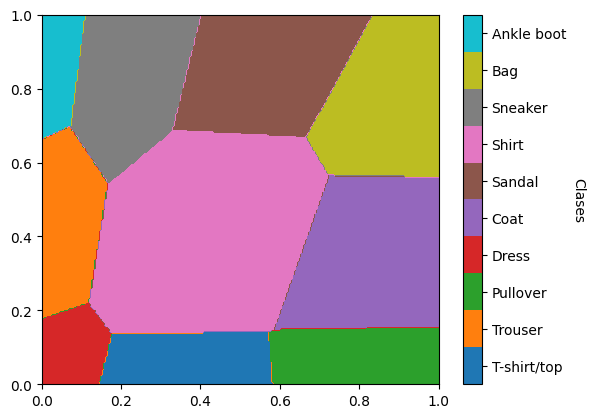

In [37]:
grid_colors = [f'C{p}' for p in list(dict.fromkeys(preds))]  # Al label p le asignamos el color Cp
Zgrid = preds.reshape((len(Y), len(X)))
levels = np.array(range(11)) - 0.5  # Corte de valores en el medio
cnt = plt.contourf(X, Y, Zgrid, levels=levels, colors=[f'C{y}' for y in range(10)])

# Color bar
cbar = plt.colorbar(cnt)
cbar.set_label("Clases", rotation = -90, va = "bottom")
cbar.set_ticks(range(10), labels=clases)
plt.show()

750/750 [==============================] - 1s 1ms/step


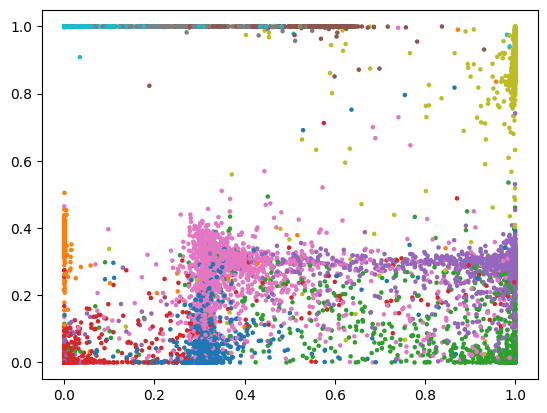

In [41]:
# Submodelo con salida en la capa intermedia
embOutmodel = keras.Model(inputs=embModel.inputs,
                        outputs=embModel.layers[-2].output)
pointsXY = embOutmodel.predict(x_val)   # Posicion en el espacio

y_pred = np.argmax(y_val, axis=-1)  # labels de los datos

plt.scatter(pointsXY[:,0], pointsXY[:,1], c=[f'C{y}' for y in y_pred], s=5)
plt.show()

Dibujamos todo junto

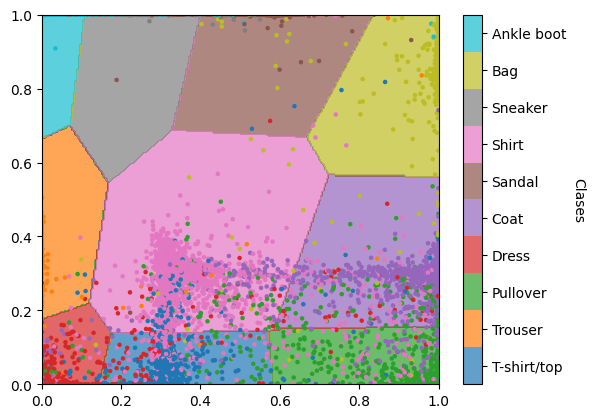

In [43]:
cnt = plt.contourf(X, Y, Zgrid, levels=levels, colors=[f'C{y}' for y in range(10)], alpha=0.7)
plt.scatter(pointsXY[:,0], pointsXY[:,1], c=[f'C{y}' for y in y_pred], s=5)
# Color bar
cbar = plt.colorbar(cnt)
cbar.set_label("Clases", rotation = -90, va = "bottom")
cbar.set_ticks(range(10), labels=clases)
plt.show()
plt.show()

Se puede notar claramente la separacion que intenta dar el modelo a los datos, aunque hay muchos que quedan en lugares que no corresponden. También se puede ver la mezcla de clases y el caso particular de la clase "Shirt"

# Predicciones

In [90]:
result = np.argmax(models2[0].predict(x_test), axis=-1)
result

313/313 [==============================] - 0s 1ms/step


array([3, 2, 7, ..., 2, 0, 7], dtype=int64)

In [91]:
df = pd.DataFrame({'id': np.arange(len(result)), 'Category': result})

df.to_csv('resultados.csv', index = False)